In [1]:
import torch
from gpzoo.gp import SVGP
from gpzoo.kernels import NSF_RBF
from gpzoo.likelihoods import NSF2
import gpzoo.pri_experiment_utilities as exp
from gpzoo.utilities import rescale_spatial_coords, dims_autocorr, regularized_nmf, add_jitter, scanpy_sizefactors, deviancePoisson, anndata_to_train_val #init_softplus
from torch.distributions import Normal
import matplotlib.pyplot as plt
from torch import nn, distributions, optim
from tqdm.auto import tqdm
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from sklearn.decomposition import NMF
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import scanpy as sc
import squidpy as sq
import random
from os import path
import csv

import warnings
warnings.filterwarnings("ignore") 

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
torch.manual_seed(256)
random_seed = 256

In [3]:
root_path = '/engelhardt/home/pshrestha/vnngp/'
rpath = path.join(root_path, "results/")
spath = path.join(rpath, "synthetic/")
ppath = path.join(rpath, "paper_figs/")

In [4]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):

    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(1, 4, figsize=(size*4, size), tight_layout=True)
        
    for i in range(L):
        plt.subplot(1, 4, i+1)
        
        curr_ax = ax[i]
        max_val = np.percentile(factors[i], 90)
        min_val = np.percentile(factors[i], 10)
        
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='Blues', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')
    return fig, ax

In [5]:
ad = sc.read_h5ad('/engelhardt/home/pshrestha/nsf-paper/simulations/bm_sp/data/S1.h5ad')
ad = ad[:,:80]
X = ad.obsm["spatial"]
D,Dval = anndata_to_train_val(ad, layer="counts", train_frac=0.8,flip_yaxis=False)
Ntr,J = D["Y"].shape

Xtr = D["X"]
ad = ad[:Ntr,:]

In [6]:
X = torch.tensor(Xtr).type(torch.float)
Y = torch.tensor(D['Y'].T).type(torch.float)

### GGblocks - Will's Paper

In [7]:
ad = sc.read_h5ad('/engelhardt/home/pshrestha/nsf-paper/simulations/bm_sp/data/S1.h5ad')

In [8]:
ad = ad[:,:80]
X = ad.obsm["spatial"]
D,Dval = anndata_to_train_val(ad, layer="counts", train_frac=0.8,flip_yaxis=False)
Ntr,J = D["Y"].shape

Xtr = D["X"]
ad = ad[:Ntr,:]

In [9]:
ad

View of AnnData object with n_obs × n_vars = 1037 × 80
    obsm: 'nsfac', 'spatial', 'spfac'
    varm: 'nsload', 'spload'
    layers: 'counts'

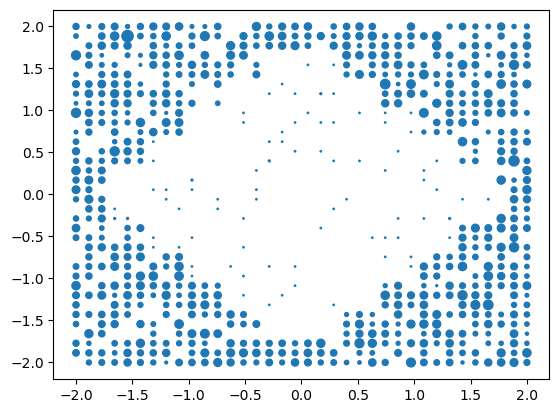

In [10]:
plt.scatter(Xtr[:,0], Xtr[:,1], s=D['Y'][:, 0], )

In [11]:
nmf_model = NMF(n_components=4, max_iter=1000, init='nndsvd', random_state=256, alpha_H=2e-1, alpha_W=1e-7)
nmf_model.fit(D['Y'])
factors = nmf_model.transform(D['Y'])
loadings = nmf_model.components_.T

In [13]:
nmf_save_path = path.join(spath, 'nmf/')
factors_path = path.join(nmf_save_path, 'factors.npy')
loadings_path = path.join(nmf_save_path, 'loadings.npy')
np.save(factors_path, factors)
np.save(loadings_path, loadings)

In [14]:
print(factors.shape)
print(loadings.shape)

(1037, 4)
(80, 4)


In [15]:
moran_idx, moranI = dims_autocorr(factors, D['X'])

In [16]:
print(moran_idx)
print(moranI)

[0 1 2 3]
[0.86338271 0.82717793 0.78152431 0.58433791]


In [17]:
X = torch.tensor(Xtr).type(torch.float)
Y = torch.tensor(D['Y'].T).type(torch.float)

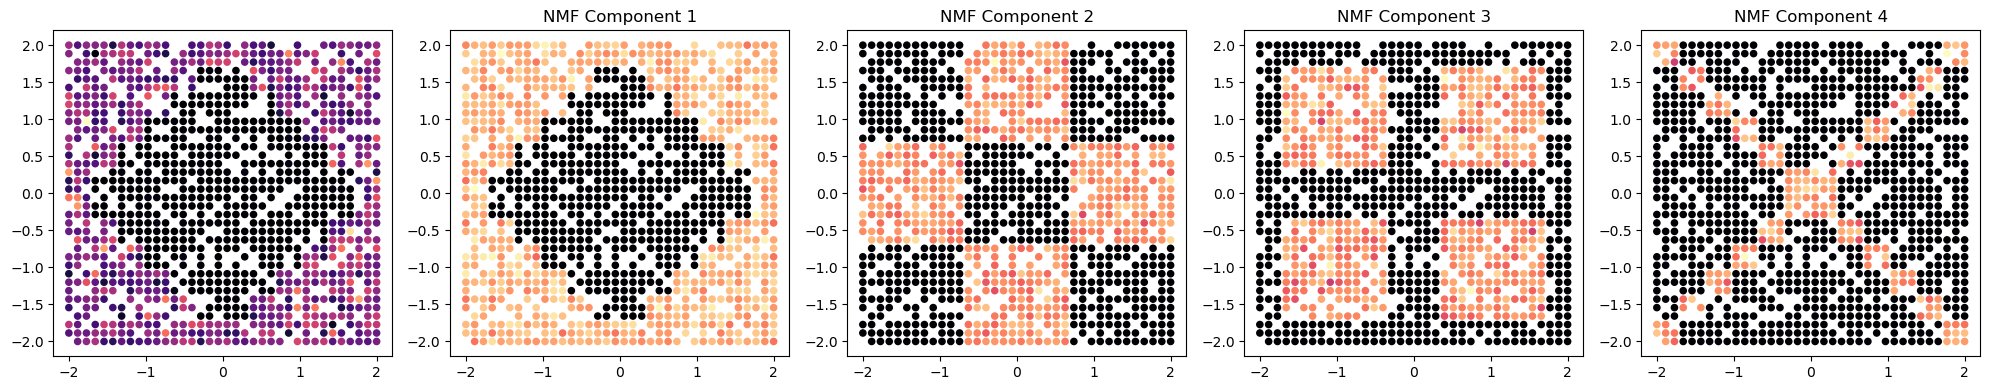

In [18]:
# Create subplots
fig, axes = plt.subplots(1, 4 + 1, figsize=(20, 4))

# Plot original data
axes[0].scatter(X[:, 0], X[:, 1], c=(Y.T)[:,9], cmap='magma', s=20)
#axes[0].set_title('Original')
#axes[0].set_xlabel('Feature 1')
#axes[0].set_ylabel('Feature 2')

# Plot each NMF component
for i in range(4):
    axes[i + 1].scatter(X[:, 0], X[:, 1], c=factors[:, i], cmap='magma', s=20)
    axes[i + 1].set_title(f'NMF Component {i + 1}')

plt.tight_layout()
plt.show()

In [19]:
factors.shape

(1037, 4)

In [20]:
X.shape

torch.Size([1037, 2])

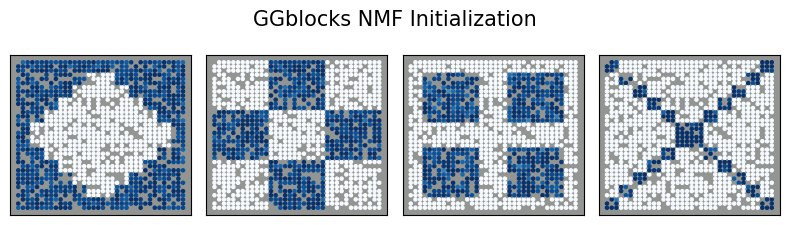

In [22]:
fig, ax = plot_factors(factors.T, X, moran_idx=None, ax=None, size=2, s=5, alpha=1)
fig.suptitle("GGblocks NMF Initialization", size=15)
fig.set_figheight(2.25)
fig.tight_layout()
#fig.savefig(path.join(ppath, 'synthetic_nmf_initialization.png'))

### NNNSF

In [22]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

In [23]:
# Normalize the data
#scaler_X = StandardScaler()
scaler_Y = StandardScaler()

#X_scale = scaler_X.fit_transform(X)
Y_scale = scaler_Y.fit_transform(Y)
Y_shifted = Y_scale - Y_scale.min() + 1 # ensure all values are positive

In [24]:
print(X.shape)
print(Y.shape)

torch.Size([1037, 2])
torch.Size([80, 1037])


In [25]:
print(factors.shape)
print(loadings.shape)

(1037, 4)
(80, 4)


In [102]:
# Define the parameter grid
param_grid = {
    'sigma': [0.1],
    'lengthscale': [0.001],
    'learning_rate': [0.001],
    'iterations': [5*3000],
    'K':[2, 3, 4, 5, 6, 7, 8, 9 ,10, 100, 300, 500]
}

model_type = 'VNNGP'
#steps = 10*1000
batched = True
NMF = True

In [103]:
print(X.shape)
print(Y.shape)

torch.Size([1037, 2])
torch.Size([80, 1037])


In [104]:
# Function to evaluate the model
def evaluate_model(model, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        model.cpu()
        qF, _, _ = model.prior(X)
        means = torch.exp(qF.mean).detach().numpy() # means = factors
        W = (model.W).cpu()
        W_transformed = nn.functional.softplus(W.T)
        W_transformed = W_transformed.detach().numpy()
        #means = scaler_Y.inverse_transform(means - 1 + Y_scale.min())
        y_nmf = ((means.T)).dot(W_transformed)
            
        # Combine Y and y_nmf for simultaneous imputation
        combined = np.hstack((Y, y_nmf.T))

        # Impute NaN values
        imputer = SimpleImputer(strategy='mean')
        combined_imputed = imputer.fit_transform(combined)

        # Split back into Y and y_nmf
        Y_imputed = combined_imputed[:, :Y.shape[1]]
        y_nmf_imputed = combined_imputed[:, Y.shape[1]:]
        #print("Y: ", Y)
        #print("y_nmf: ", y_nmf)
        #print("Y_imputed: ", Y_imputed)
        #print("y_nmf_imputed: ", y_nmf_imputed)
        #reconstruction_error = mean_squared_error(Y_imputed, y_nmf_imputed)
        reconstruction_error = mean_squared_error(Y_scale, y_nmf.T)
        
    return reconstruction_error

In [ ]:

# Open the CSV file to log the results
with open('synthetic_nsf_cv_results.csv', mode='w', newline='') as file:
    #writer = csv.writer(file)
    # Write the header
    #writer.writerow(['learning_rate', 'sigma', 'lengthscale', 'mean_cv_loss'])

    # Iterate over each parameter combination
    for params in ParameterGrid(param_grid):
        # Update the parameter dictionary
        dicts = {
                'L': 4, 
                'M': len(X), # use total number of inducing points
                'sigma': params['sigma'], 
                'lengthscale': params['lengthscale'], 
                'jtr': 0.1,
                'batch_size': 128,
                'lr': params['learning_rate'],
                'rs': 256,
                'lkzz_build': 1,
                'model': 'VNNGP',
                'L1_jitter': 1e-2,
                'K': params['K']
            }

        kwargs = dicts

        file_path = model_type
        if model_type == 'VNNGP':
            file_path += f"_K={kwargs['K']}"
            if kwargs['lkzz_build']:
                file_path += f"_lkzz={kwargs['lkzz_build']}"
        file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}__ls={kwargs['lengthscale']}_sigma={kwargs['sigma']}_bs={kwargs['batch_size']}"
        if batched:
            file_path += f"_bs={kwargs['batch_size']}"
        if NMF:
            file_path += f"_NMFinit"
            X_array = np.array(X)
            Y_array = np.array(Y_shifted)
            moran_idx, moranI = exp.dims_autocorr(factors, X_array)
            factors = factors[:, moran_idx]
            loadings = loadings[:, moran_idx]
            model = exp.build_model(X_array, Y_array, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)

        exp.model_grads(model)
        model.prior.jitter = kwargs['jtr']
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
        model.to(device)
        X_torch = torch.tensor(X).type(torch.float).to(device)
        Y_torch = torch.tensor(Y_shifted).type(torch.float).to(device)

        start_time = time.time()
        losses, means, scales, idxs = exp.train_batched(model, optimizer, X_torch, Y_torch, device,
                                                                          steps=80000, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)
        end_time = time.time()
        final_time = end_time - start_time

        with torch.no_grad():
                X_torch = torch.tensor(X).type(torch.float)
                Y_torch = torch.tensor(Y).type(torch.float)
                val_loss = exp.evaluate_model(model, X_torch.cpu(), Y_torch, device, kwargs=kwargs)
        
        mean_cv_loss = np.mean(val_loss)
        print(f'Params: {params}, Mean CV Loss: {mean_cv_loss}')

        #Write the results to the CSV file
        #writer.writerow([params['learning_rate'], params['sigma'], params['lengthscale'], mean_cv_loss])
        save_path = path.join(spath, 'nnnsf')
        model_state_path = f'{save_path}/{file_path}_state_dict.pth'
        model_info_path = f'{save_path}/{file_path}_model.pt'
        torch.save(model.state_dict(), model_state_path)
        torch.save({
                            'losses': losses,
                            'means': means,
                            'scales': scales,
                            'time': final_time
                    }, model_info_path)
        

        fig, ax = plt.subplots()
        ax.plot(losses)
        fig.suptitle(f"{model_type} Loss | sigma: {params['sigma']}, lengthscale: {params['lengthscale']}")
        fig1.savefig(f'{save_path}/{file_path}_loss.png')
        plt.show()

        model.cpu()
        qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
        mean = torch.exp(qF.mean).detach().numpy()
        plot_factors(mean, X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=5, alpha=1, ax=None)
        fig.suptitle("GGblocks NSF", size=15)
        fig2.savefig(f'{save_path}/{file_path}_factors.png')
        fig.set_figheight(2.25)
        fig.tight_layout()
        plt.show()
        model.to(device)

  0%|          | 0/80000 [00:00<?, ?it/s]

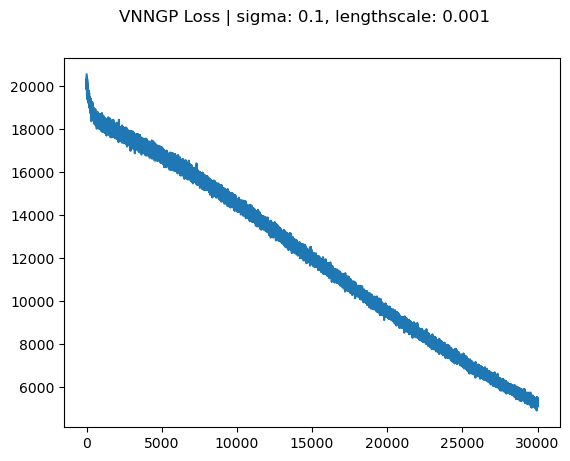

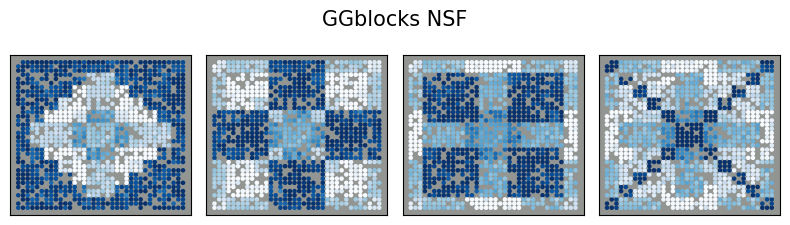

NSF2(
  (prior): VNNGP(
    (kernel): NSF_RBF()
  )
)

In [82]:
save_path = path.join(spath, 'nnnsf')
model_state_path = f'{save_path}/{file_path}_state_dict.pth'
model_info_path = f'{save_path}/{file_path}_model.pt'
torch.save(model.state_dict(), model_state_path)
torch.save({
                            'losses': losses,
                            'means': means,
                            'scales': scales,
                            'time': final_time
                    }, model_info_path)
        

fig, ax = plt.subplots()
ax.plot(losses)
fig.suptitle(f"{model_type} Loss | sigma: {params['sigma']}, lengthscale: {params['lengthscale']}")
fig.savefig(f'{save_path}/{file_path}_loss.png')
plt.show()

model.cpu()
qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
mean = torch.exp(qF.mean).detach().numpy()
fig2, ax = plot_factors(mean, X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=5, alpha=1, ax=None)
fig2.suptitle("GGblocks NSF", size=15)
fig2.set_figheight(2.25)
fig2.tight_layout()
plt.show()
fig2.savefig(f'{save_path}/{file_path}_factors.png')
model.to(device)

In [83]:
final_loss = losses
X_torch = torch.tensor(X).type(torch.float).to(device)
Y_torch = torch.tensor(Y_shifted).type(torch.float).to(device)

In [ ]:
start_time = time.time()
losses, means, scales, idxs = exp.train_batched(model, optimizer, X_torch, Y_torch, device,
                                                                          steps=30000, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)
end_time = time.time()
final_time += end_time - start_time
final_loss += losses

  0%|          | 0/30000 [00:00<?, ?it/s]

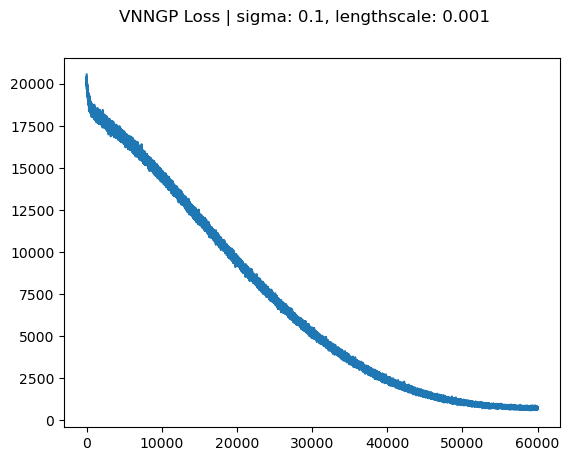

In [85]:
fig, ax = plt.subplots()
ax.plot(final_loss)
fig.suptitle(f"{model_type} Loss | sigma: {params['sigma']}, lengthscale: {params['lengthscale']}")
plt.show()

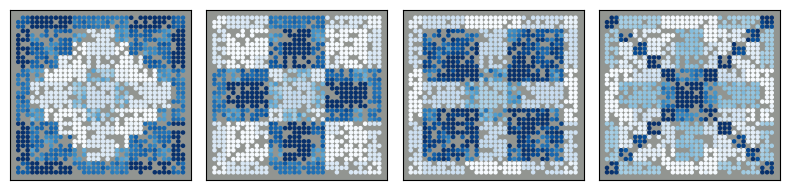

NSF2(
  (prior): VNNGP(
    (kernel): NSF_RBF()
  )
)

In [86]:
model.cpu()
qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
mean = torch.exp(qF.mean).detach().numpy()
plot_factors(mean, X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=5, alpha=1, ax=None)
fig.suptitle("GGblocks NSF", size=15)
fig.set_figheight(2.25)
fig.tight_layout()
plt.show()
model.to(device)

In [95]:
X_torch = torch.tensor(X).type(torch.float).to(device)
Y_torch = torch.tensor(Y_shifted).type(torch.float).to(device)
start_time = time.time()
losses, means, scales, idxs = exp.train_batched(model, optimizer, X_torch, Y_torch, device,
                                                                          steps=10000, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)
end_time = time.time()
final_time += end_time - start_time
final_loss += losses

  0%|          | 0/10000 [00:00<?, ?it/s]

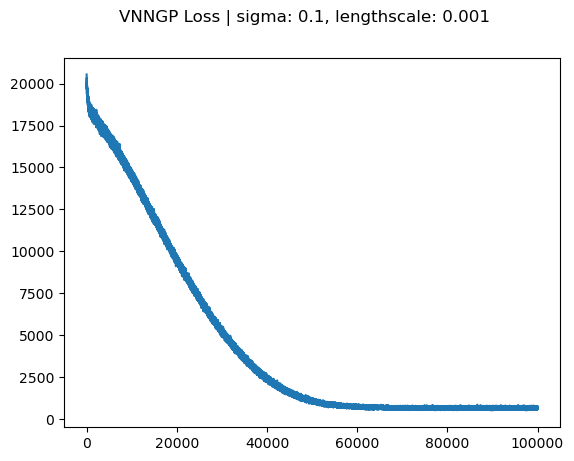

In [96]:
fig, ax = plt.subplots()
ax.plot(final_loss)
fig.suptitle(f"{model_type} Loss | sigma: {params['sigma']}, lengthscale: {params['lengthscale']}")
plt.show()

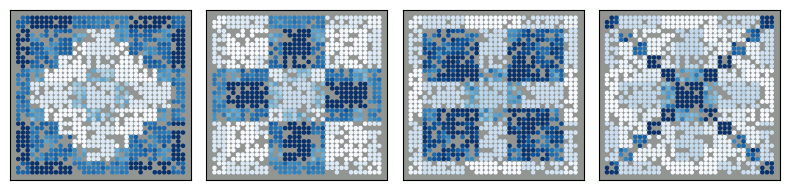

NSF2(
  (prior): VNNGP(
    (kernel): NSF_RBF()
  )
)

In [97]:
model.cpu()
qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
mean = torch.exp(qF.mean).detach().numpy()
plot_factors(mean, X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=5, alpha=1, ax=None)
fig.suptitle("GGblocks NSF", size=15)
fig.set_figheight(2.25)
fig.tight_layout()
plt.show()
model.to(device)

In [101]:
save_path = path.join(spath, 'nnnsf')
model_state_path = f'{save_path}/{file_path}_state_dict.pth'
model_info_path = f'{save_path}/{file_path}_model.pt'
torch.save(model.state_dict(), model_state_path)
torch.save({'losses': losses,
            'means': means,
            'scales': scales,
            'time': final_time}, model_info_path)

## NSF

In [23]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

In [24]:
# Normalize the data
#scaler_X = StandardScaler()
scaler_Y = StandardScaler()

#X_scale = scaler_X.fit_transform(X)
Y_scale = scaler_Y.fit_transform(Y)
Y_shifted = Y_scale - Y_scale.min() + 1 # ensure all values are positive

In [38]:
model_type='SVGP'
batched = True
# Open the CSV file to log the results
with open('synthetic_nsf_cv_results.csv', mode='w', newline='') as file:
    #writer = csv.writer(file)
    # Write the header
    #writer.writerow(['learning_rate', 'sigma', 'lengthscale', 'mean_cv_loss'])

    # Iterate over each parameter combination
    #for params in ParameterGrid(param_grid):
        # Update the parameter dictionary
    dicts = {
                'L': 4, 
                'M': len(X), # use total number of inducing points
                'sigma': 0.1, 
                'lengthscale': 0.0001, 
                'jtr': 0.1,
                'batch_size': 128,
                'lr': 0.001,
                'rs': 256,
                'lkzz_build': 1,
                'model': 'SVGP',
                'L1_jitter': 1e-2,
        }

    kwargs = dicts

    file_path = model_type
    if model_type == 'VNNGP':
        file_path += f"_K={kwargs['K']}"
        if kwargs['lkzz_build']:
            file_path += f"_lkzz={kwargs['lkzz_build']}"
    file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}__ls={kwargs['lengthscale']}_sigma={kwargs['sigma']}_bs={kwargs['batch_size']}"
    if batched:
        file_path += f"_bs={kwargs['batch_size']}"
    if NMF:
        file_path += f"_NMFinit"
        X_array = np.array(X)
        Y_array = np.array(Y_shifted)
        moran_idx, moranI = exp.dims_autocorr(factors, X_array)
        factors = factors[:, moran_idx]
        loadings = loadings[:, moran_idx]
        model = exp.build_model(X_array, Y_array, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)

    exp.model_grads(model)
    model.prior.jitter = kwargs['jtr']
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
    model.to(device)
    X_torch = torch.tensor(X).type(torch.float).to(device)
    Y_torch = torch.tensor(Y_shifted).type(torch.float).to(device)

    start_time = time.time()
    losses, means, scales, idxs = exp.train_batched(model, optimizer, X_torch, Y_torch, device,
                                                                          steps=10000, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)
    end_time = time.time()
    final_time = end_time - start_time

    with torch.no_grad():
            X_torch = torch.tensor(X).type(torch.float)
            Y_torch = torch.tensor(Y).type(torch.float)
            val_loss = exp.evaluate_model(model, X_torch.cpu(), Y_torch, device, kwargs=kwargs)

  0%|          | 0/10000 [00:00<?, ?it/s]

Params: {'L': 4, 'M': 1037, 'sigma': 0.1, 'lengthscale': 0.001, 'jtr': 0.1, 'batch_size': 128, 'lr': 0.001, 'rs': 256, 'lkzz_build': 1, 'model': 'SVGP', 'L1_jitter': 0.01}, Mean CV Loss: 12.002382278442383


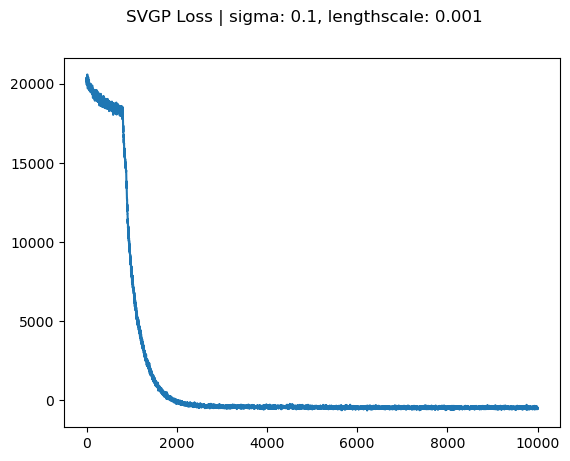

In [36]:
mean_cv_loss = np.mean(val_loss)
print(f'Params: {dicts}, Mean CV Loss: {mean_cv_loss}')

#Write the results to the CSV file
#writer.writerow([dicts['learning_rate'], dicts['sigma'], dicts['lengthscale'], mean_cv_loss])
#save_path = path.join(spath, 'nsf')
#model_state_path = f'{save_path}/{file_path}_state_dict.pth'
#model_info_path = f'{save_path}/{file_path}_model.pt'
#torch.save(model.state_dict(), model_state_path)
#torch.save({
    #'losses': losses,
    #'means': means,
    #'scales': scales,
    #'time': final_time
#}, model_info_path)
        

fig, ax = plt.subplots()
ax.plot(losses)
fig.suptitle(f"{model_type} Loss | sigma: {dicts['sigma']}, lengthscale: {dicts['lengthscale']}")
#fig1.savefig(f'{save_path}/{file_path}_loss.png')
plt.show()

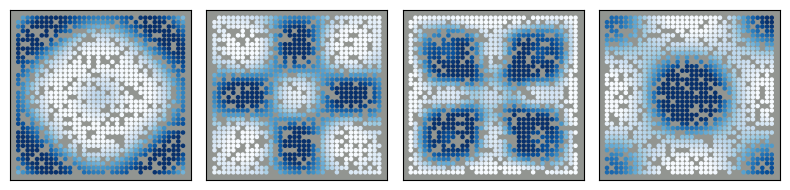

NSF2(
  (prior): SVGP(
    (kernel): NSF_RBF()
  )
)

In [37]:
model.cpu()
qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
mean = torch.exp(qF.mean).detach().numpy()
plot_factors(mean, X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=5, alpha=1, ax=None)
fig.suptitle("GGblocks NSF", size=15)
#fig2.savefig(f'{save_path}/{file_path}_factors.png')
fig.set_figheight(2.25)
fig.tight_layout()
plt.show()
model.to(device)